<center>
<h1>236606 - Machine Learning and Human Behavior</h1>
<h2>Homework #2 - Discrete Choice ✨</h2>
</center>

## Preliminaries
Run these cells to load into memory objects and functions that will be used throughtout the homework.

In [4]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import abc
import string
import statsmodels.api as sm
import itertools
from sklearn import svm, linear_model
import pandas as pd
import sys
import pickle as pkl

from collections import OrderedDict

%config InlineBackend.figure_format = 'retina'

In [2]:
#@title Context Effect
# user model types

# Generate Choice

class UserModel(abc.ABC):
  @abc.abstractclassmethod
  def __call__(self, X, *args):
    '''
    Given items X, calculate the user's valuation v(x) for each item x
    '''
    raise NotImplementedError()

  def predict(self, X, *args):
    raise NotImplementedError()


class RationalUserModel(UserModel):

  def __init__(self, num_features, beta_h):
    self.num_features = num_features
    self.beta_h = beta_h
    self.type = "rational"

  def __call__(self, X):
    return X@self.beta_h

  def choice(self, X):
    return np.argmax(self(X), axis=0)


class AttractionUserModel(UserModel):
  def __init__(self, beta_h, alpha_attr):
    # rational_utility_weights
    self.rational_utility_weights = beta_h
    # attraction_coefficient
    self.attraction_coefficient = alpha_attr
    self.name = "attraction"

  def __call__(self, X):
    # X: shape=(num_items,num_features) - Item covariates
    return (
        self._rational_decision_term(X)
        + self.attraction_coefficient*self._attraction_term(X)
    )

  def _rational_decision_term(self, X):
    return X@self.rational_utility_weights

  def _attraction_term(self, X):
    # Calculate preference vector
    preference_vector = X.max(axis=0)-X.min(axis=0)
    preference_vector_normalized = (
        preference_vector
        /np.sqrt(preference_vector@preference_vector)
    )
    # Calculate dominance and distance matrices
    N = len(X)
    dominance = np.zeros((N,N))
    distance = np.zeros((N,N))
    for i in range(N):
      for j in range(N):
        dominance[i,j] = (+1)*np.all(X[i]-X[j] >= 0) + (-1)*np.all(X[j]-X[i] >= 0)
        distance[i,j] = abs(preference_vector_normalized@(X[i]-X[j]))

    attraction_terms = (dominance*distance).sum(axis=1)
    return attraction_terms

  def choice(self, X):
    return np.argmax(self(X), axis=0)

In [3]:
#@title Context Effects Environment


class DiscreteChoiceEnvironment:
    """
    Generic class for discrete-choice dataset generation
    """
    n_features = 8
    observations_per_user = 10
    items_per_slate = 1
    train_user_proportion = 0.6

    def _generate_user_item_attributes(self, n_users):
        """
        Generate latent parameters for users and items.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, items_per_slate, n_features)
        """
        users = np.random.normal(
            size=(
                n_users,
                self.n_features,
            ),
        )
        items = np.random.normal(
            size=(
                n_users,
                self.observations_per_user,
                self.items_per_slate,
                self.n_features,
            ),
        )
        return users, items

    def _choice(self, users, items):
        """
        Discrete choice function

        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, items_per_slate, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        raise NotImplementedError

    def _generate_choice_dataset(self, n_users):
        """
        Generate choice dataset, formatted as pandas dataframe.
        """
        users, items = self._generate_user_item_attributes(n_users)
        choice_dct = self._choice(users, items)
        rows = []
        for i in range(n_users):
            for j in range(self.observations_per_user):
                dct = {}
                dct['user_id'] = f'{i}'
                dct['slate_id'] = f'{i}_{j}'
                for k in range(self.items_per_slate):
                    for l in range(self.n_features):
                        dct[f'x_{k},{l}'] = items[i,j,k,l]
                for choice_type, choice_matrix in choice_dct.items():
                    dct[choice_type] = choice_matrix[i,j]
                rows.append(dct)
        df = pd.DataFrame(rows)
        return df

    def generate_datasets(self, n_users):
        n_train_users = int(n_users*self.train_user_proportion)
        n_test_users = n_users - n_train_users
        return (
            self._generate_choice_dataset(n_train_users),
            self._generate_choice_dataset(n_test_users),
        )


class ContextChoiceEnvironment(DiscreteChoiceEnvironment):
    """
    Dataset generator for binary choice with decision noise
    """
    def __init__(self,
                 slate_number=1,
                 observations_per_user=50,
                 num_items_omega=15):

        # self.noise_scale = noise_scale
        self.user_model = AttractionUserModel(
                          beta_h=np.array([1,9]),
                          alpha_attr=3,
                          )
        self.slate_number = slate_number
        self.observations_per_user = observations_per_user
        self._generate_ex1_items(slate_number=slate_number,
                                 num_items_omega=num_items_omega)


    def _generate_ex1_items(self, slate_number=1, num_items_omega=15):
      if slate_number == 1:
        self.omega = np.array([[10,3,3,4,8,4,1],[1,7,5,4,5,6,1]])
        self.E_s = np.array([20, 90, 80, 40, 30, 80, 100])
        self.omega_tag = np.array([[4,2.5,4.5],[4.5,6,5]])
        self.E_s_tag = np.array([5, 8, 3])

      elif slate_number == 2:
        self.omega = np.array([[3,8,8.5,4,10,8,2, 1],[8,7,4,4,5,6,1, 8]])
        self.E_s = np.array([10, 90, 30, 50, 30, 40,100,90])

        self.omega_tag = np.array([[4,3,4.5,6],[8,6,5,6]])
        self.E_s_tag = np.array([5, 8, 3, 9])

      else:
        np.random.seed(42)
        num_items_omega = 15
        self.omega, self.omega_tag = list(), list()
        self.E_s, self.E_s_tag = list(), list()

        for i in range(self.observations_per_user):
          self.omega.append(np.hstack([np.zeros((num_items_omega, 1)),
                                        np.ones((num_items_omega, 1))*i,
                                        np.random.randint(
                                            20,size=(num_items_omega,2)),
                                       np.random.randint(
                                           20,100,size=(num_items_omega,1))
                                        ]
                                       )
          )

          self.omega_tag.append(np.hstack([np.zeros((100, 1)),
                              np.ones((100, 1))*i,
                              np.random.randint(
                                  20,size=(100,2)),
                              np.random.randint(20,size=(100,1))
                              ]
                              )
          )

        self.omega = np.vstack(self.omega).T
        self.omega_tag = np.vstack(self.omega_tag).T
      return

    def _items_to_frame(self, omega, E_s, char_start=ord('A')):

        data = pd.DataFrame(omega.T).reset_index()
        if len(data) < self.observations_per_user:
          data['user_id'] = np.zeros(len(data))
          data['slate_id'] = np.zeros(len(data))
          data['rantional_user_val'] = omega.T@\
                            self.user_model.rational_utility_weights
          data["E_s"] = E_s

        else:
          data['rantional_user_val'] = data.loc[:,[2,3]].values@\
                  self.user_model.rational_utility_weights

          data.rename(columns={0:'user_id', 1:'slate_id',
                               2:'x_0', 3:'x_1', 4:'E_s'},
                      inplace=True)

        data['name'] = data['index'].apply(lambda x: chr(char_start+x))

        return data


    def inspect_data(self, items_type="current", slate_id=-1):

      if items_type == "current":
        data =  self._items_to_frame(self.omega,self.E_s)
      elif items_type == "tag":
        data =  self._items_to_frame(self.omega_tag, self.E_s_tag, ord('A') + len(self.E_s)+1) #todo: change this

      return data


    def generate_datasets(self):

      data = pd.DataFrame(self.omega.T).reset_index()
      if len(data) < self.observations_per_user:

        data['user_id'] = np.zeros(len(data))
        data['slate_id'] = np.zeros(len(data))
        data['name'] = data['index'].apply(lambda x: chr(ord('A')+x))
        data['rantional_user_val'] = self.omega.T@\
                                    self.user_model.rational_utility_weights
        self.top_5 = data.rantional_user_val.argsort()[-5:][::-1]
        data['top_5'] = data['index'].apply(lambda x: x in self.top_5.values)
        data['perceived_val'] = np.nan
        data.loc[self.top_5, ['perceived_val']] = self.user_model(data.loc[self.top_5, [0,1]].values)
        data = self._choice(data)

      return data


    def _choice(self, data):
        dummies = pd.get_dummies(data['index'])
        # for name, group in grouped:
        self.chosen = data['perceived_val'].idxmax()
        data['chosen'] = dummies.iloc[data['perceived_val'].idxmax(), :]
        return data

    def add_item(self, index):
      self.omega = np.hstack([self.omega,self.omega_tag[:,index].reshape(2,1)])
      self.E_s =np.hstack([self.E_s,self.E_s_tag[1]])
      return

    def pop_item(self):
      self.omega = self.omega[:,:-1]
      self.E_s =self.E_s[:-1]
      return

    def top_5(self, rantional_user_val):
      return rantional_user_val.argsort()[-5:][::-1]

    def plot_omega(self):
      area = 20

      self.generate_datasets()
      fig, ax = plt.subplots()
      ax.scatter(self.omega[0,:], self.omega[1,:], s=80,label="$\Omega$")
      plt.title('Items in $\Omega$', fontsize=20)
      plt.xlabel('$X_1$')
      plt.ylabel('$X_2$')
      plt.grid()
      # # color the top three items
      ax.scatter(self.omega[0,self.top_5], self.omega[1,self.top_5], s=80, color='red')
      # add annotations
      S_len = self.omega.shape[1]
      for i, txt in enumerate(string.ascii_uppercase[:S_len]):
          ax.annotate(txt, (self.omega[0,:][i]+0.05, self.omega[1,:][i]+0.07))
      ax.scatter(self.omega[0,self.chosen], self.omega[1,self.chosen], s=80, color='red',edgecolors='black',linewidths=2)

      plt.show()

    def plot_two_sets(self):
      area = 20

      fig, ax = plt.subplots()
      ax.scatter(self.omega[0,:], self.omega[1,:], s=80,label="$\Omega$")
      plt.title('Items in both sets', fontsize=20)
      plt.xlabel('$X_1$')
      plt.ylabel('$X_2$')
      plt.grid()
      # inspect set of decoyes
      ax.scatter(self.omega_tag[0,:],self.omega_tag[1,:], s=80, label="$\Omega'$")
      plt.legend(loc='lower right')


      # add annotations and print user values
      S_len = self.omega.shape[1]
      Sw_s = S_len + 1
      Sw_len = Sw_s + self.omega_tag.shape[1]
      for i, txt in enumerate(string.ascii_uppercase[:S_len]):
          ax.annotate(txt, (self.omega[0,:][i]+0.05, self.omega[1,:][i]+0.07))

      for i, txt in enumerate(string.ascii_uppercase[Sw_s:Sw_len]):
          ax.annotate(txt, (self.omega_tag[0,:][i]+0.1, self.omega_tag[1,:][i]+0.1))
      plt.show()

      return




-----------------
-----------------

## Ex 1: engineering choice sets

In this task, you will play "evil designer" and construct sets of available items that cause (non-rational) users to choose items that are bad for them (i.e., have suboptimal value), but good for the system. In particular, users in this task will be susceptible to the *Attracttion* context effect, and the way you construct the set of items should make use of this knowledge.

----------------------------------------

**Recommendation procedure:**
1. The collection of available items is the *ground set* $\Omega=\{x_1,...,x_n\}$ ($n$ may be different in different parts of this task). Each item $x \in s$ is described by two features, $x=(x_1, x_2)$.
2. There is a single user whose (true) value function is $v(x)=\alpha^\top x$. I.e., if the user chooses item $x_i$, then she receives $\alpha_1\cdot x_{i1} + \alpha_2\cdot x_{i2}$ utility from this choice. **The value vector $\alpha$ is known to the system**.
3. System also benefits from user choices. If the user chooses item $x_i$, then the system receives $e_i$ utility. The values $e_i$ are predetermined, known to the system, and do not depend on features.
4. The system recommends to the user the top-5 items $x\in \Omega$ having highest value. We will call this the *choice set*, denoted $s \in \Omega$.
5. The user chooses exactly one item $x \in s$. This is the item with highest *perceived value*, as determined by the attraction effect:
$$
  \tilde{v}(x|s) = \alpha^\top x + \mathtt{att}(x|s)
$$
where $\mathtt{att}$ is as was defined in class. We will denote the chosen item by $y = \mathtt{argmax}_{x \in s} \tilde{v}(x|s)$.
6. User receives utility $v(y)$, and system receives utility $e_y$.

----------------------------------------

In the above description, the system recommends in a way that is optimal to users. In this task, *you are an agent of the system*, and your goal is to maximize the system's utility.

Of course, you cannot simply force the user to choose a certain item, nor can you change the recommendation procedure. The only thing you are allowed to do is to modify $\Omega$ by adding one additional item from a different set of items, $\Omega'$. Once $\Omega$ is modified (i.e., includes one additional item), the recommendation procedure and user choice behavior is as described above.
Hence, your goal is to (manually) choose $x \in \Omega$ such that the choice $y$ derived from a top-5 recommended set $s$ based on the collection of items $\Omega \cup \{x\}$ will results in high system utility $e_y$ (and possibly with lower utility $v(y)$ to the user).

As you will see, items in  $\Omega'$ actually have lower system values $e_i$ than items in $\Omega$ ($\forall e \in E_S, e' \in E_S':  e > e'$). Therefore, the item you add will serve as a *decoy*: these serve to modify the preceived values of items in $s$, in a way that utilizes the attraction effect to affect choice behavior.

### 1.1 Guided example - a gentle start:

Set $\Omega$ consists of 7 items:

\begin{align}
{A:(1,10), B:(3,7), C:(3,5), D:(4,4), E:(8,5), F:(4,6), G:(1,1)}
\end{align}

with the following system utility values $e_s=\{e_1,\dots,e_n\}$:
\begin{align}
\{20, 90, 80, 40, 30, 80, 100\}
\end{align}

Additionally, we have set $\Omega'$:
\begin{align}
{I:(4,4.5), J:(2.5,6), K:(4.5,5)}
\end{align}
with the following values $e_{s'}$:
\begin{align}
\{5, 8, 3\}
\end{align}

The parameter $\alpha$ of the user value function is:
\begin{align}
\alpha_1 = 1, \alpha_2 = 9
\end{align}


1.1.1 First, let's see what happens before you intervene. Run the code below to see what 5 items are recommended by the system when $\Omega$ is the ground set,
and what item the user chooses. Make sure you understand what the code does.

In [4]:
attraction_env = ContextChoiceEnvironment()
attraction_env.inspect_data(items_type="current")

,index,0,1,user_id,slate_id,rantional_user_val,E_s,name
0,0,10,1,0.0,0.0,19,20,A
1,1,3,7,0.0,0.0,66,90,B
2,2,3,5,0.0,0.0,48,80,C
3,3,4,4,0.0,0.0,40,40,D
4,4,8,5,0.0,0.0,53,30,E
5,5,4,6,0.0,0.0,58,80,F
6,6,1,1,0.0,0.0,10,100,G


In [5]:
attraction_env.inspect_data(items_type="tag")

,index,0,1,user_id,slate_id,rantional_user_val,E_s,name
0,0,4.0,4.5,0.0,0.0,44.5,5,I
1,1,2.5,6.0,0.0,0.0,56.5,8,J
2,2,4.5,5.0,0.0,0.0,49.5,3,K


1.1.2 Use ```generate_datasets``` method to print a table showing for each of Omega's items (rows) the true value and perceived value for the user (columns). save results to variable ```df```and print

In [6]:
df = attraction_env.generate_datasets()
df

,index,0,1,user_id,slate_id,name,rantional_user_val,top_5,perceived_val,chosen
0,0,10,1,0.0,0.0,A,19,False,NaN,False
1,1,3,7,0.0,0.0,B,66,True,69.086975,False
2,2,3,5,0.0,0.0,C,48,True,27.934666,False
3,3,4,4,0.0,0.0,D,40,True,25.079623,False
4,4,8,5,0.0,0.0,E,53,True,77.695796,True
5,5,4,6,0.0,0.0,F,58,True,65.202941,False
6,6,1,1,0.0,0.0,G,10,False,NaN,False


1.1.3 Use
```plot_omega``` method to plot all items in 2D space and highlights the top-5 items and the user's choice:

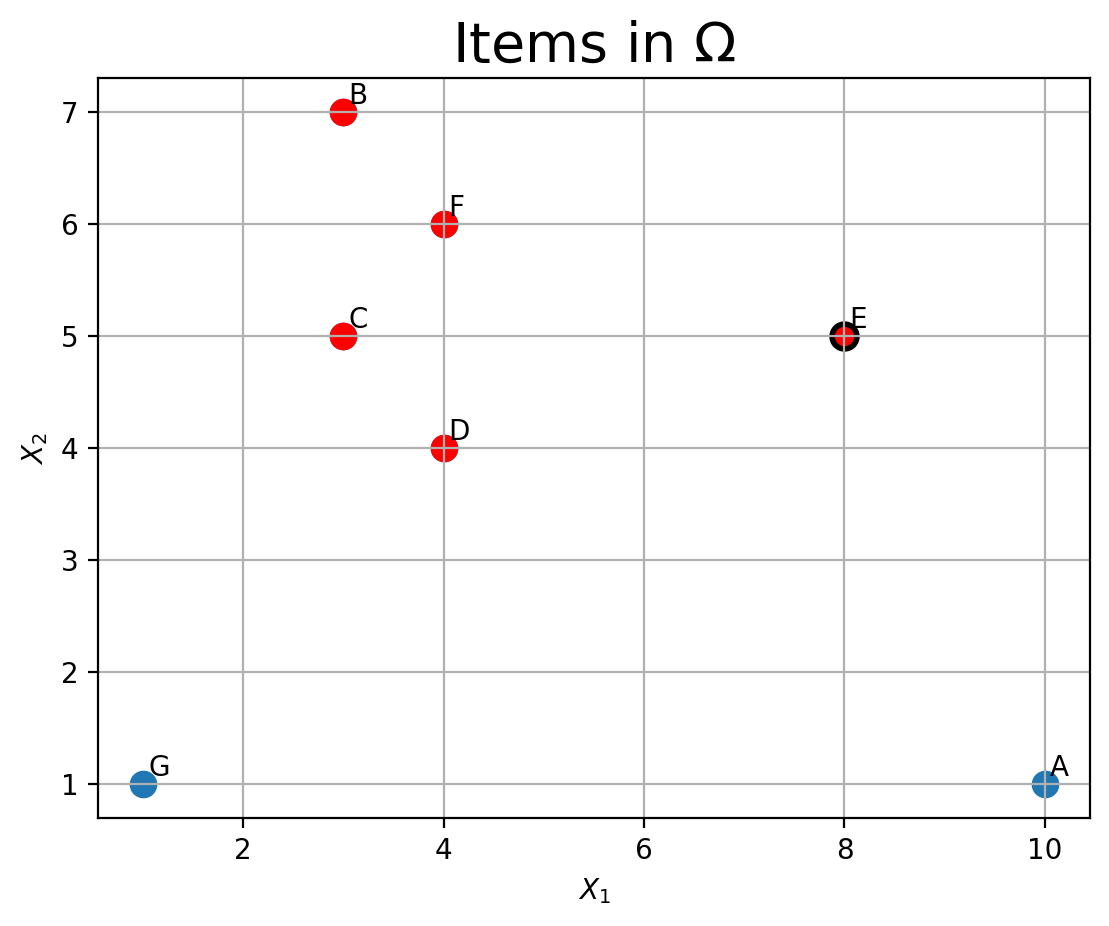

In [7]:
attraction_env.plot_omega()

In the above plot, items in $\Omega$ are dots. Top-5 items that are currently selected from $\omega$ are colored red, and all others are blue. The chosen item has a black border.

Some things to note:
* Items C and D are dominated by E and F (make sure you understand what this means, and why it holds).
* User chooses item E, meaning it has the highest perceived value. Here, item E also has the highest true value, and so the user is happy.
* The value to the system form the user choosing item E is $e_E=20$.

1.1.4
What can you do to improve the system's utility?
The next block of code plots items in both $\Omega$ and $\Omega'$ in 2D space:

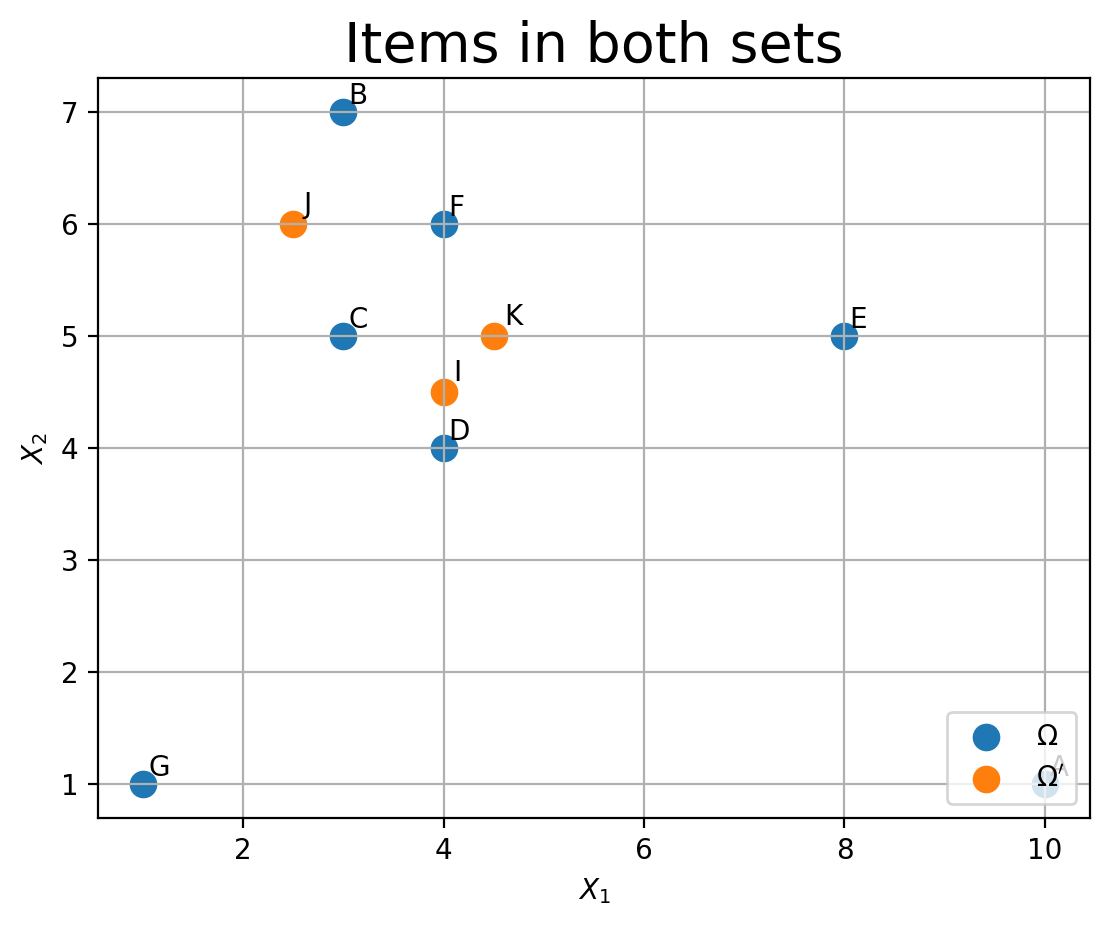

In [8]:
attraction_env.plot_two_sets()

Examine the plot. Using your knowledge about how the attraction effect works, think: if you are allowed to add one item from $\Omega'$ to $\Omega$, and if you are interested in maximizing system utility - which item would you add?

Write your answer, and provide an explanation for your choice.



```
Answer: When Looking at the options the user will choose from, it is clear that E and F dominate C and D. They are strictly better in every paramater. 
Also, When looking at the set of 5 top items, B has the highest system value (90). And so, we want to use attraction to make B chosen instead of E. We have 3 choices of items to add:
K - It is dominated by E (and not by either F or B) and  E has the highest distance from it,  so it will not change the result.
I - It is also dominated by E. F dominates I also, but because E has higher distance than I, still E will be the main benefitor (attraction = distance * <if dominated> * constant)
J - It is not dominated by E and is dominated by F and B. Meaning this item will help the most to change the result so E won't be chosen and F or B will be Chosen instead. The distance of B and F from J is pretty similar and B has higher true value, and so B will probably Be chosen here.
P.S: If we can Add J to *replace* an item from the recommanded set, we will remove D as it is Dominated by E and not by B.
```

1.1.5 Next, let's examine what happens when we add $H$ to $\Omega$:

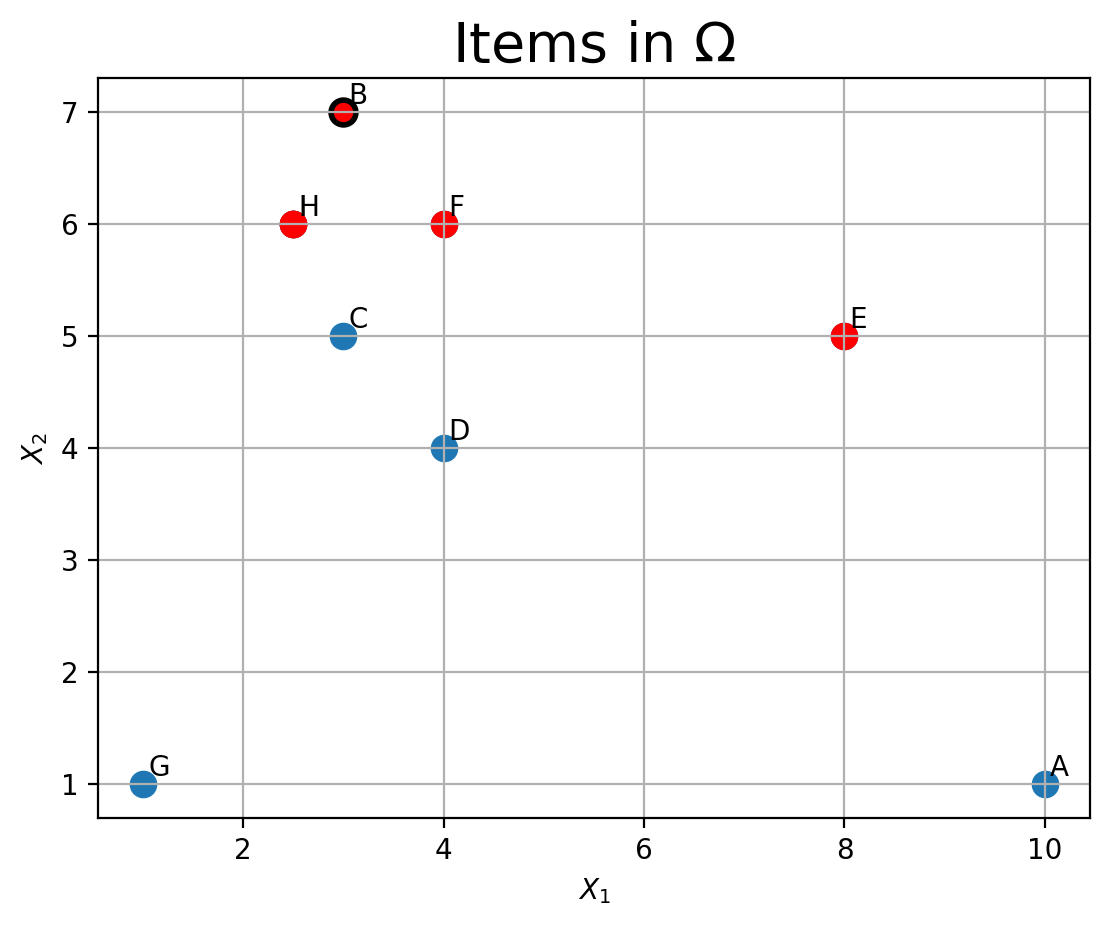

In [11]:
# plot over scatter
# Add new item to S
index = 1 #this is the index of H in Omega'
attraction_env.add_item(index=index)

attraction_env.plot_omega()

Print a table of true value, perceived value, and system utility for all top-5 items:

In [12]:
df_new = attraction_env.generate_datasets()
df_new.loc[df_new['top_5']]

,index,0,1,user_id,slate_id,name,rantional_user_val,top_5,perceived_val,chosen
1,1,3.0,7.0,0.0,0.0,B,66.0,True,70.869839,True
4,4,8.0,5.0,0.0,0.0,E,53.0,True,53.000000,False
5,5,4.0,6.0,0.0,0.0,F,58.0,True,66.458141,False
7,7,2.5,6.0,0.0,0.0,H,56.5,True,49.836010,False
8,8,2.5,6.0,0.0,0.0,I,56.5,True,49.836010,False


Notice how $H$ contributed to the perceived value of $B$, just enough to make it more appealing than $E$.

Congrats! The system now gets $e_B=90$ utility! (recall it was 30 before)

1.1.6 Finally, let's compute:
* welfare - this is the actual value to the user from choice
* regret - this is the gap between the percieved value and true value of the chosen item
(if there were more than one user, we would measure the average).

Run the following code blocks and print welfare and regret for Omega before and after adding the additional item.


In [19]:
# welfare
## YOUR SOLUTION
welfare_before = df.loc[df['perceived_val'].idxmax(), 'rantional_user_val']
welfare_after = df_new.loc[df_new['perceived_val'].idxmax(), 'rantional_user_val']
print(f"wellfare before: {welfare_before}, wellfare after: {welfare_after}")



wellfare before: 53, wellfare after: 66.0


In [22]:
# regret
## YOUR SOLUTION
preceived_val_all_after = df_new.loc[df_new['perceived_val'].idxmax(), 'perceived_val']
preceived_val_all_before = df.loc[df['perceived_val'].idxmax(), 'perceived_val']
regret_before = np.abs(welfare_before - preceived_val_all_before)
regret_after = np.abs(welfare_after - preceived_val_all_after)
print(f"regret before: {regret_before}, regret after: {regret_after}")

regret before: 24.695796260521263, regret after: 4.869838648985535


### 1.2 **Now You: Find an item to add without any guidance**

In this section, your goal is to repeat the task of finding an item to add, but without guidance - we will just give you the sets $\Omega$ and $\Omega'$.


In [62]:
# New data:
attraction_env = ContextChoiceEnvironment(slate_number=2)
attraction_env.inspect_data(items_type="current")

,index,0,1,user_id,slate_id,rantional_user_val,E_s,name
0,0,3.0,8.0,0.0,0.0,75.0,10,A
1,1,8.0,7.0,0.0,0.0,71.0,90,B
2,2,8.5,4.0,0.0,0.0,44.5,30,C
3,3,4.0,4.0,0.0,0.0,40.0,50,D
4,4,10.0,5.0,0.0,0.0,55.0,30,E
5,5,8.0,6.0,0.0,0.0,62.0,40,F
6,6,2.0,1.0,0.0,0.0,11.0,100,G
7,7,1.0,8.0,0.0,0.0,73.0,90,H


In [63]:
attraction_env.inspect_data(items_type="tag")

,index,0,1,user_id,slate_id,rantional_user_val,E_s,name
0,0,4.0,8.0,0.0,0.0,76.0,5,J
1,1,3.0,6.0,0.0,0.0,57.0,8,K
2,2,4.5,5.0,0.0,0.0,49.5,3,L
3,3,6.0,6.0,0.0,0.0,60.0,9,M


1.2.1 Add code in the given blocks to generate relevant scatter plots. Use these to reason about which item to add - write your answer and explanation in the relevant blocks.


In [64]:
df = attraction_env.generate_datasets()
df

,index,0,1,user_id,slate_id,name,rantional_user_val,top_5,perceived_val,chosen
0,0,3.0,8.0,0.0,0.0,A,75.0,True,80.692100,True
1,1,8.0,7.0,0.0,0.0,B,71.0,True,71.948683,False
2,2,8.5,4.0,0.0,0.0,C,44.5,False,NaN,False
3,3,4.0,4.0,0.0,0.0,D,40.0,False,NaN,False
4,4,10.0,5.0,0.0,0.0,E,55.0,True,55.000000,False
5,5,8.0,6.0,0.0,0.0,F,62.0,True,61.051317,False
6,6,2.0,1.0,0.0,0.0,G,11.0,False,NaN,False
7,7,1.0,8.0,0.0,0.0,H,73.0,True,67.307900,False


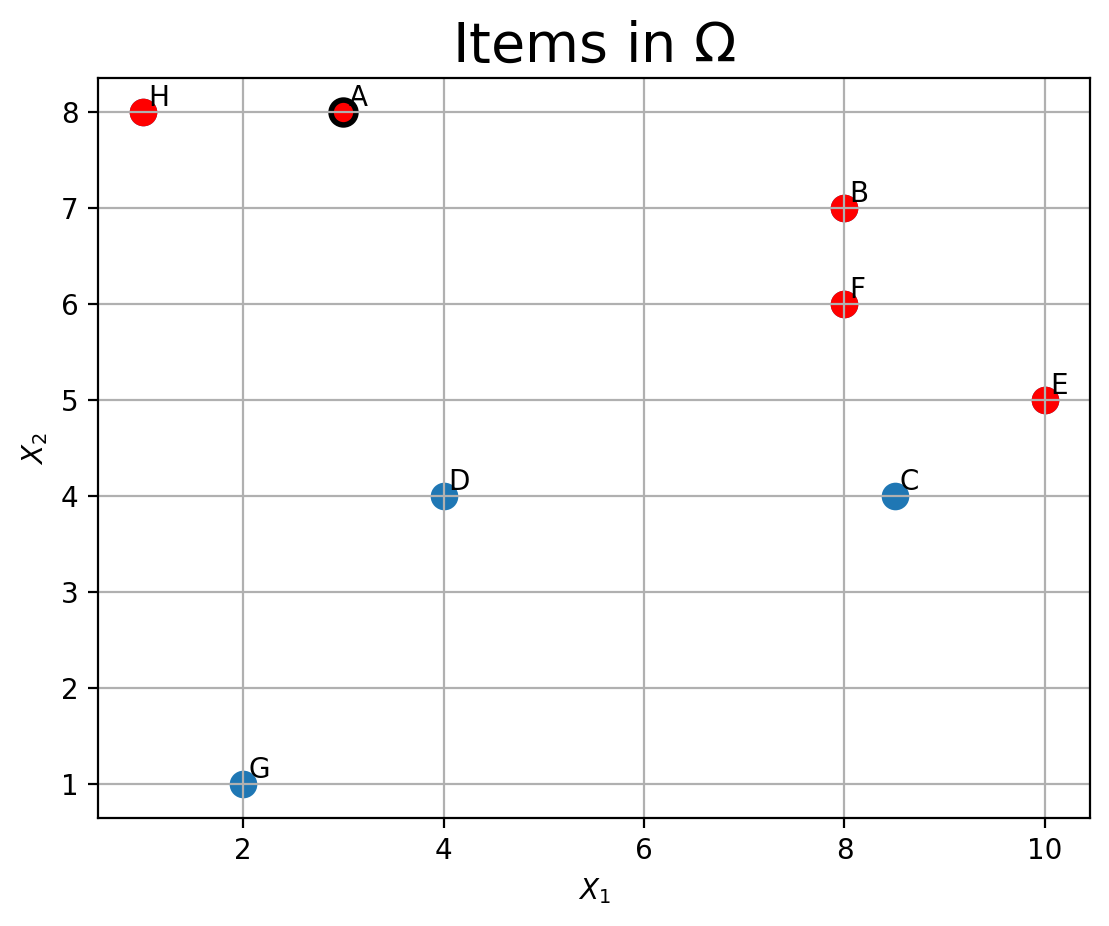

In [65]:
## YOUR SOLUTION
attraction_env.plot_omega()

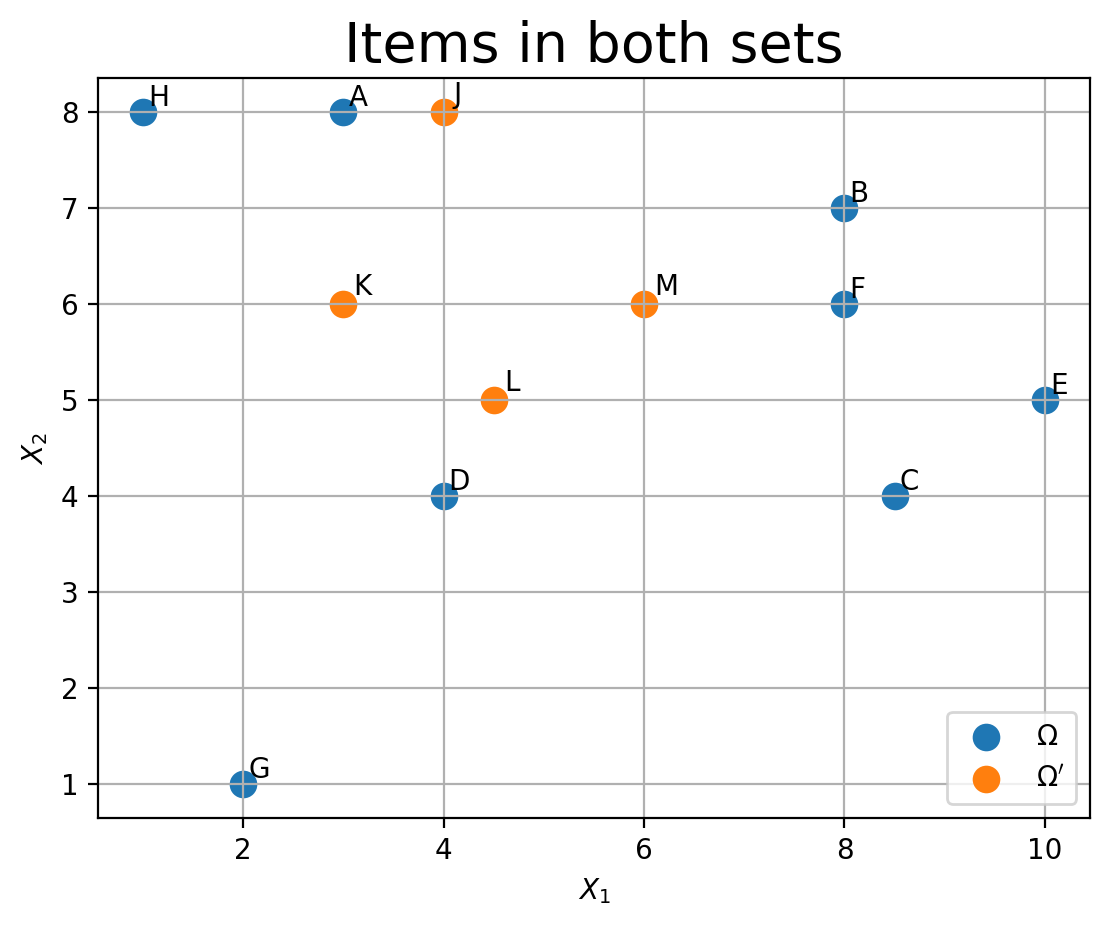

In [66]:
## YOUR SOLUTION
attraction_env.plot_two_sets()

**Which item will you add and why?** (you can use the code to experiment)



````
Answer: When Looking at the options the user will choose from, it is clear that A, which is the item that recieve the most rational value (and percieved value in the original dataset) gives the system the lowest value - so any modification will improve this for the system. 
Point G, which gives the most system value, will not be chosen (because it's rational value is too low) and item H will never be chosen over item A (as A dominates H). so we need to focus on maximizing the value - which is them item B. Also, When looking at the set of 5 top items, B has the highest system value of all of them (90). And so, we want to use attraction to make B chosen instead of A. We have 4 choices of items to add:
J - Which has lower system value then A but also dominates A - which then will make the user chose J and the system value will decrease.
L - this item has lower rational value (49.5) then the current top 5 items in the set - it will not be chosen and the attrection value will stay the same - choosing A again.
M - while at first sight it seems that M will improve the system's utility (B dominates M), as it helps attrects item B (and not item A), the delta in attrection we get for item B by adding item M is not enough for item B to be percieved more then item A.
K - this item is dominated by both A and B, so at first glance it will help them both and therefore will not help B become more valued then A. but if we take the distance of the Items, we see item B is way further from item K them item A. This distance helps B overcome A, as Item B will be percieved as more valuable.
P.S: Each item we add will remove item E from the top 5 items (besides from item L) and item E is not dominated be any other item.
```



1.2.2 Add code to generate the final plot, showing recommendations and choice after you have added the additional item.

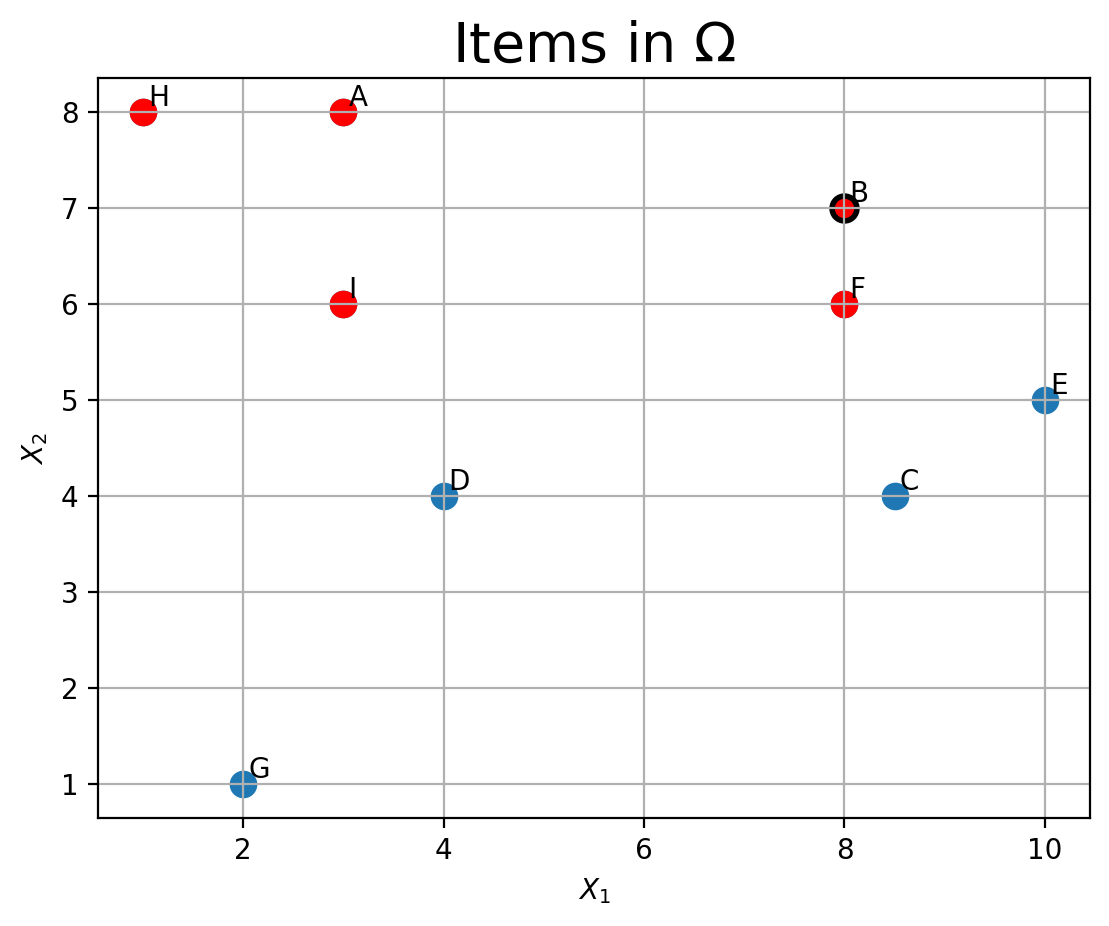

In [67]:
## YOUR SOLUTION
# Add new item to S
# let's add the third item in the tag set to the current set
index = 1 #this is the index of H in Omega'
attraction_env.add_item(index=index)

attraction_env.plot_omega()

df_new = attraction_env.generate_datasets()


In [69]:
df_new

,index,0,1,user_id,slate_id,name,rantional_user_val,top_5,perceived_val,chosen
0,0,3.0,8.0,0.0,0.0,A,75.0,True,82.417470,False
1,1,8.0,7.0,0.0,0.0,B,71.0,True,87.071186,True
2,2,8.5,4.0,0.0,0.0,C,44.5,False,NaN,False
3,3,4.0,4.0,0.0,0.0,D,40.0,False,NaN,False
4,4,10.0,5.0,0.0,0.0,E,55.0,False,NaN,False
5,5,8.0,6.0,0.0,0.0,F,62.0,True,75.598696,False
6,6,2.0,1.0,0.0,0.0,G,11.0,False,NaN,False
7,7,1.0,8.0,0.0,0.0,H,73.0,True,67.230856,False
8,8,3.0,6.0,0.0,0.0,I,57.0,True,25.681791,False


1.2.3 Calculate welfare and regret for before and after adding the additional item. Print your results.


In [68]:
## YOUR SOLUTION
welfare_before = df.loc[df['perceived_val'].idxmax(), 'rantional_user_val']
welfare_after = df_new.loc[df_new['perceived_val'].idxmax(), 'rantional_user_val']
print(f"wellfare before: {welfare_before}, wellfare after: {welfare_after}")
preceived_val_all_after = df_new.loc[df_new['perceived_val'].idxmax(), 'perceived_val']
preceived_val_all_before = df.loc[df['perceived_val'].idxmax(), 'perceived_val']
regret_before = np.abs(welfare_before - preceived_val_all_before)
regret_after = np.abs(welfare_after - preceived_val_all_after)
print(f"regret before: {regret_before}, regret after: {regret_after}")

wellfare before: 75.0, wellfare after: 71.0
regret before: 5.692099788303082, regret after: 16.07118598199662


# Ex 2: your ranker

Here you implement your ranking algorithm class.

Load Train and test datasets:

In [19]:
import pickle
import numpy as np

# Load test data
with open('test.pkl', 'rb') as f:
    test_data = pickle.load(f)

with open('test_labels.pkl', 'rb') as f:
    test_labels = pickle.load(f)

# Load train data
with open('train.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('train_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)
    

def add_dimension(data, idx):
    keys = np.unique(data[:, idx])
    groups = {}
    for key in keys:
        groups[key] = data[data[:, idx] == key]
        groups[key] = np.delete(groups[key], idx, axis=1)
    return np.array([groups[key] for key in keys])
    
    
    

train_data = add_dimension(train_data, 0)
test_data = add_dimension(test_data, 0)
train_labels = add_dimension(train_labels, 1)
train_labels = train_labels.squeeze(axis=2)
train_labels = np.argmax(train_labels, axis=1)
test_labels = test_labels.reshape(-1,7)
test_labels = np.argmax(test_labels, axis=1)


Your Ranker implementation

In [49]:
## YOUR SOLUTION
    
def transform_pairwise(choice_set, y):
    """
    Creates a binary dataset from a list of choice sets and chosen items.
    
    :param choice_sets: List of arrays. Each element is an array of shape (m_i, d) representing a choice set.
    :param chosen_items: List of arrays. Each element is a 1D array of shape (d,) representing the chosen item.
    
    :return: X_bar, y_bar
        X_bar: np.array of shape (M, d) where M is the total number of generated pairwise comparisons
        y_bar: np.array of shape (M,) where labels are in {+1, -1}
    """
    X_bar = []
    y_bar = []
    np.random.seed(42)

    
    for i, possible_item in enumerate(choice_set):
        if i == y:
            continue
        
        s = 1 if np.random.rand() < 0.5 else -1
        
        x_bar = s*(y - possible_item)
        label = s
        
        X_bar.append(x_bar)
        y_bar.append(label)
    
    X_bar = np.array(X_bar)
    y_bar = np.array(y_bar)
    return X_bar, y_bar

In [51]:
class MyRanker(svm.LinearSVC):
    def shape_transform(self, X, y):
        """
        Transforms the input dataset into a binary-labeled dataset using transform_pairwise.
        
        :param X: numpy array of shape (m, n, q)
        :param y: numpy array of shape (m,)
        :return: X_prime, y_prime
            X_prime: numpy array of shape (m_prime, n_prime, q)
            y_prime: numpy array of shape (m_prime,)
        """
        # Apply transform_pairwise to each example in the input dataset
        X_prime = []
        y_prime = []
        
        for i in range(len(X)):
            X_i, y_i = transform_pairwise(X[i], y[i])
            X_prime.append(X_i)
            y_prime.append(y_i)
        
        # Concatenate the transformed examples
        X_prime = np.concatenate(X_prime)
        y_prime = np.concatenate(y_prime)
        
        return X_prime, y_prime
    
    def fit(self, X, y):
        """
        Fits svm.LinearSVC to the transformed binary-labeled dataset.
        
        :param X: numpy array of shape (m, n, q)
        :param y: numpy array of shape (m,)
        :return: self
        """
        print(X.shape)
        X_prime, y_prime = self.shape_transform(X, y)
        print(X_prime.shape)
        super().fit(X_prime, y_prime)
        return self
    
    def predict(self, X):
        """
        Predicts using the argmax rule and the coefficients of the learned SVM model.
        
        :param X: numpy array of shape (m, n, q)
        :return: y, numpy array of shape (m,), index of top choice per slate
        """
        y_pred = []
        for slate in range(len(X)):
            y_pred.append(np.argmax([self.decision_function(X[slate])]))
        return np.array(y_pred)
    

ranker = MyRanker(max_iter=100 )

# X, y = ranker.shape_transform(train_data, train_labels)
ranker.fit(train_data, train_labels)
y_pred = ranker.predict(test_data)  
print(f'acc: {np.mean(y_pred == test_labels)}')


(400, 7, 5)
(2400, 5)
acc: 0.8


/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test Your ranker with the example inputs, print accuracy.

In [52]:
## YOUR SOLUTION
print(f'acc: {np.mean(ranker.predict(train_data)  == train_labels)}')

acc: 0.7575
